Beam size modified to: 200μm x 200μm
Detector updated to Mercu 1717V parameters:
  Pixel size: 139.0μm x 139.0μm
  Pixel matrix: 3072 x 3072
  Physical size: 427.0mm x 427.0mm
  Detector distance: 1324.9mm
Sample diameter modified to: 4000.0μm (i.e., 2mm)
Sample material: Nickel, structural information loaded from Ni.cif
Base orientation set: Crystal [1 1 0] direction || Beam [1 0 0] direction
Adding a maximum of 3.0° random orientation spread to the sample...
Target orientation grains generated for all 637 elements.
Rendering 17 scattering volumes unto the detector       |████████████████████████████████████████| 100.0%
原始数据最大值: 103785876931.63
为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: 36508898594.54 (有效信号的95百分位)


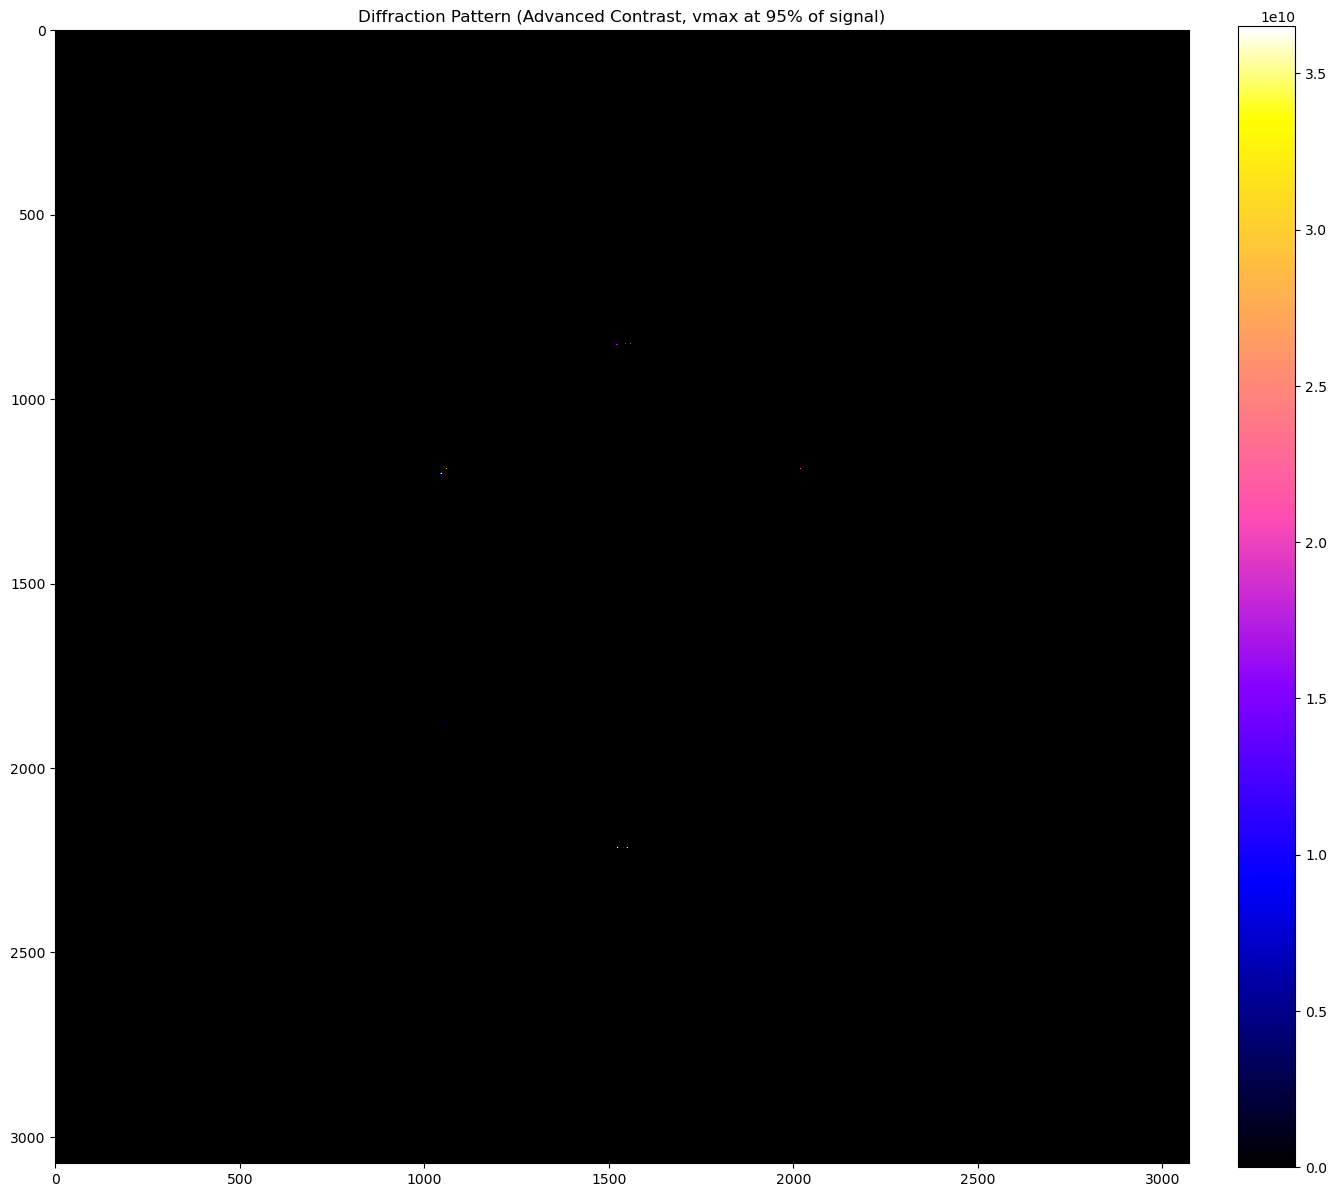

In [1]:
import numpy as np
from xrd_simulator.beam import Beam
from xrd_simulator.detector import Detector
from xrd_simulator.mesh import TetraMesh
from xrd_simulator.phase import Phase
from xrd_simulator.polycrystal import Polycrystal
from xrd_simulator.motion import RigidBodyMotion
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- Beam Definition (Modified) ---
beam = Beam(
    np.array([
        [-5e6, -100., -100.], [-5e6, 100., -100.], [-5e6, 100., 100.], [-5e6, -100., 100.],
        [5e6, -100., -100.], [5e6, 100., -100.], [5e6, 100., 100.], [5e6, -100., 100.]
    ]),
    xray_propagation_direction=np.array([1., 0., 0.]),
    wavelength=0.1258,
    polarization_vector=np.array([0., 1., 0.])
)
print("Beam size modified to: 200μm x 200μm")

# --- Detector Definition (Unit Correction) ---

# 1. Define parameters in physically intuitive units
detector_distance_mm = 1324.9   # Define detector distance explicitly in millimeters (mm) 
pixel_size_um = 139.0        # Define pixel size explicitly in micrometers (μm)
number_of_pixels = 3072

# 2. Unify all units to micrometers (μm) as required by the simulation
detector_distance_um = detector_distance_mm * 1000   # Convert mm to μm
detector_size_um = number_of_pixels * pixel_size_um
half_detector_size = detector_size_um / 2.0

# 3. Create the detector object; all coordinate components are now in μm
detector = Detector(
    pixel_size_z=pixel_size_um,
    pixel_size_y=pixel_size_um,
    det_corner_0=np.array([detector_distance_um, -half_detector_size, -half_detector_size]),
    det_corner_1=np.array([detector_distance_um,  half_detector_size, -half_detector_size]),
    det_corner_2=np.array([detector_distance_um, -half_detector_size,  half_detector_size])
)

print(f"Detector updated to Mercu 1717V parameters:")
print(f"  Pixel size: {pixel_size_um}μm x {pixel_size_um}μm")
print(f"  Pixel matrix: {number_of_pixels} x {number_of_pixels}")
print(f"  Physical size: {detector_size_um/1000:.1f}mm x {detector_size_um/1000:.1f}mm")
print(f"  Detector distance: {detector_distance_um / 1000:.1f}mm")

# --- Geometry Definition (Modified) ---
new_radius = 2000.0 # 2mm diameter = 2000μm diameter = 1000μm radius
mesh = TetraMesh.generate_mesh_from_levelset(
    level_set=lambda x: np.linalg.norm(x) - new_radius,
    bounding_radius=new_radius + 1.0,   # Bounding radius slightly larger than sample radius
    max_cell_circumradius=600.) # Can also adjust mesh size proportionally
print(f"Sample diameter modified to: {2*new_radius}μm (i.e., 2mm)")

# --- 2. Define Crystal Properties of Nickel (Ni) (Final Correction) ---
# Define the basic parameters, as required by the class
nickel_unit_cell = [3.52, 3.52, 3.52, 90., 90., 90.]
nickel_sgname = 'Fm-3m'

# Provide ALL required arguments to the Phase class
nickel_phase = Phase(
    unit_cell=nickel_unit_cell,
    sgname=nickel_sgname,
    path_to_cif_file='Ni.cif'  # Or 'Nickel.cif', whichever you named it
)

print(f"Sample material: Nickel, structural information loaded from {nickel_phase.path_to_cif_file}")

# --- 3. Define a near-single crystal with a specific orientation ([110] incidence) ---

# A. Calculate base orientation: Align the crystal's [110] direction with the beam
crystal_direction_to_align = np.array([1, 1, 0])
beam_direction_in_lab = np.array([1, 0, 0]) # Beam propagation direction
base_rotation_object, _ = R.align_vectors([beam_direction_in_lab], [crystal_direction_to_align])
print(f"Base orientation set: Crystal {crystal_direction_to_align} direction || Beam {beam_direction_in_lab} direction")

# B. Add a 3° random orientation spread to the new base orientation (this logic is unchanged)
max_misorientation_degrees = 3.0
max_misorientation_radians = np.radians(max_misorientation_degrees)
orientations_with_spread = []

print(f"Adding a maximum of {max_misorientation_degrees}° random orientation spread to the sample...")
for _ in range(mesh.number_of_elements):
    # Generate a small random rotation
    random_axis = np.random.randn(3)
    if np.linalg.norm(random_axis) > 1e-8:
        random_axis /= np.linalg.norm(random_axis)
    random_angle = np.random.rand() * max_misorientation_radians
    small_random_rotation = R.from_rotvec(random_angle * random_axis)

    # Final orientation = small random rotation * base rotation
    final_rotation = small_random_rotation * base_rotation_object
    
    orientations_with_spread.append(final_rotation.as_matrix())

# Convert the list of orientations to a numpy array for the simulator
single_crystal_orientation = np.array(orientations_with_spread)
print(f"Target orientation grains generated for all {mesh.number_of_elements} elements.")

# --- 4. Assemble into a single crystal sample (Modified) ---
polycrystal = Polycrystal(
    mesh=mesh,
    orientation=single_crystal_orientation,
    strain=np.zeros((3, 3)),
    phases=[nickel_phase], # <-- Put the single object into a list
    element_phase_map=None
)

# --- 5. Execute Simulation and Rendering (Unchanged) ---
motion = RigidBodyMotion(
    rotation_axis=np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)]),
    rotation_angle=np.radians(1.0),
    translation=np.array([0., 0., 0.])  # <-- Add the required translation parameter
)
polycrystal.diffract(beam, detector, motion)
diffraction_pattern = detector.render(frames_to_render=0)

# --- 6. 显示结果 (高级对比度调整) ---
fig, ax = plt.subplots(1, 1, figsize=(16, 15))

# 1. 从衍射数据中，只筛选出所有强度大于0的像素点（即有效信号）
positive_intensities = diffraction_pattern[diffraction_pattern > 0]

# 2. 检查是否存在有效信号
if positive_intensities.size > 0:
    # 仅对有效信号计算颜色映射的上下限
    vmin_val = 0  # 我们希望背景（强度为0）是色谱的最低颜色
    
    # 在有效信号中寻找一个合适的上限，例如99.0%或95.0%，这会显示出更多细节
    vmax_percentile = 95
    vmax_val = np.percentile(positive_intensities, vmax_percentile)
else:
    # 如果图中没有任何衍射信号，则使用一个默认范围
    vmin_val = 0
    vmax_val = 1
    print("警告：衍射图中未找到任何有效信号。")

print(f"原始数据最大值: {diffraction_pattern.max():.2f}")
print(f"为增强对比度，仅对非零信号计算，颜色上限(vmax)设为: {vmax_val:.2f} (有效信号的{vmax_percentile}百分位)")

# 3. 渲染图像，并传入新的vmin和vmax
im = ax.imshow(
    diffraction_pattern,
    cmap='gnuplot2', # 'plasma' 或 'viridis' 是很好的科学可视化色谱
    interpolation='nearest',
    vmin=vmin_val,
    vmax=vmax_val
)

# 4. 添加颜色条
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_title(f"Diffraction Pattern (Advanced Contrast, vmax at {vmax_percentile}% of signal)")
plt.show()

In [2]:
import math

from matplotlib.cbook import silent_list

# 1. 定义角度
angle_degrees = 5

# 2. 将角度转换为弧度
angle_radians = math.radians(angle_degrees)

# 3. 计算 2 * tan(弧度值)
thickness = 5
result = thickness * math.tan(angle_radians)

edge_length = 0.5 - result

# 4. 打印结果
print(f"{thickness} * tan(5°) 的计算结果是: {result}")
print(f"{thickness}mm厚度下透光孔径的计算结果是: {edge_length}")
# 输出: 2 * tan(5°) 的计算结果是: 0.17496033832342413

5 * tan(5°) 的计算结果是: 0.43744331762962
5mm厚度下透光孔径的计算结果是: 0.06255668237037998
